# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [11]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg, max, min
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier,LinearSVC, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# import pandas, matplotlib, and seaborn for visualization and EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

In [12]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Data Frames practice") \
    .getOrCreate()

# df = spark.read.json("mini_sparkify_event_data.json")
df = spark.read.json("medium-sparkify-event-data.json")

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [13]:
# take a look at how data looks like
df.head()

Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293')

In [14]:
# take a look at the dataframe schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [15]:
# look at the row counts
print('Total row counts:' + str(df.count()))
print('Total unique row counts:' + str(df.distinct().count()))

Total row counts:543705
Total unique row counts:543705


In [16]:
# look at the missing values
for col in df.columns:
    print(col + ':' + str(df.filter(df[col].isNull()).count()))

artist:110828
auth:0
firstName:15700
gender:15700
itemInSession:0
lastName:15700
length:110828
level:0
location:15700
method:0
page:0
registration:15700
sessionId:0
song:110828
status:0
ts:0
userAgent:15700
userId:0


It looks like the following columns have the same missing values (15700):

- firstName
- gender
- lastName
- location
- registration
- userAgent

Also, following columns have the same number of missing values (110828):

- artist
- length
- song

It's likely that these rows are missing at the same place

In [17]:
# remove the missing rows
# if registration is missing then columns such as firstName, gender, and location are also missing
df = df.filter(df.registration.isNotNull())
for col in df.columns:
    print(col + ':' + str(df.filter(df[col].isNull()).count()))

artist:95128
auth:0
firstName:0
gender:0
itemInSession:0
lastName:0
length:95128
level:0
location:0
method:0
page:0
registration:0
sessionId:0
song:95128
status:0
ts:0
userAgent:0
userId:0


In [18]:
df.count()

528005

In [19]:
df.toPandas().head(10)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martin Orford,Logged In,Joseph,M,20,Morales,597.55057,free,"Corpus Christi, TX",PUT,NextSong,1532063507000,292,Grand Designs,200,1538352011000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",293
1,John Brown's Body,Logged In,Sawyer,M,74,Larson,380.21179,free,"Houston-The Woodlands-Sugar Land, TX",PUT,NextSong,1538069638000,97,Bulls,200,1538352025000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",98
2,Afroman,Logged In,Maverick,M,184,Santiago,202.37016,paid,"Orlando-Kissimmee-Sanford, FL",PUT,NextSong,1535953455000,178,Because I Got High,200,1538352118000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179
3,None,Logged In,Maverick,M,185,Santiago,NaN,paid,"Orlando-Kissimmee-Sanford, FL",PUT,Logout,1535953455000,178,None,307,1538352119000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179
4,Lily Allen,Logged In,Gianna,F,22,Campos,194.53342,paid,"Mobile, AL",PUT,NextSong,1535931018000,245,Smile (Radio Edit),200,1538352124000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,246
5,Carter USM,Logged In,Sofia,F,266,Gordon,138.29179,paid,"Rochester, MN",PUT,NextSong,1533175710000,162,Airplane Food,200,1538352125000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",163
6,None,Logged In,Maverick,M,190,Santiago,NaN,paid,"Orlando-Kissimmee-Sanford, FL",GET,Home,1535953455000,178,None,200,1538352176000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179
7,Aerosmith,Logged In,Lacey,F,107,Castaneda,220.39465,free,"El Campo, TX",PUT,NextSong,1537536032000,442,Walk This Way,200,1538352215000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_...",175
8,None,Logged In,Colin,M,0,Larson,NaN,free,"Dallas-Fort Worth-Arlington, TX",GET,Home,1537982255000,497,None,200,1538352241000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) G...,100
9,Amy Winehouse,Logged In,Colin,M,1,Larson,201.50812,free,"Dallas-Fort Worth-Arlington, TX",PUT,NextSong,1537982255000,497,Teach Me Tonight,200,1538352259000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) G...,100


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

## Define Churn
Let's define churn as Cancellation Confirmation

In [20]:
# this function flags 1 if there's any cancellation confirmation event (churn_event column)
flag_churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn('churn_event', flag_churn_event('page'))

# below creates "churn" column and places 1 if there's churn_event for a particular user
windowval = Window.partitionBy('userId')
df_churn = df.withColumn('churn', max('churn_event').over(windowval))

## Exploratory Data Analysis
Let's conduct EDA and understand the data from various angles. To start with, let's first understand what information each column contains. Some of the fields are very intuitive, such as firstName, lastName and artist, but some are not so obvious. For example:

- First of all, how many percentage of users have churned?
- What are the possible pages which users can visit?
- What does 'status' mean?
- What is 'userAgent'?

### How many percentage of users have churned?
Let's look first look at how many percentage of users have churned. This is important to understand, as it related to the metric we can employ (e.g. if data is skewed to one particilar class, accuracy isn't a good measure). Also, this also helps gauge the performance of naive baseline model, which always flag churn or no-churn.

In [21]:
churn_df = df_churn.dropDuplicates(['userId']).groupby('churn').count().toPandas()
churn_df.head(5)

,churn,count
0,1,99
1,0,349


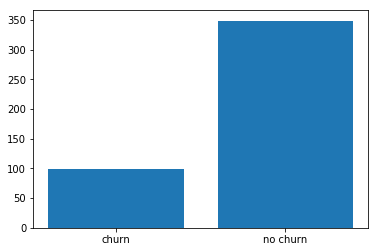

In [22]:
plt.bar([0,1],churn_df['count'].values)
plt.xticks([0,1], ['churn', 'no churn'], fontsize=10)
plt.show()

It looks like it is skewed towawrds no-churn(as expected! if it is skewed towards more churn then the business won't exist). It's roughly about 100 / 450, which is around 22%. Alternatively, <b>naive model of always predicting 'no-churn' has the performance of 78% accuracy</b>.

### Page
Below is the distribution of the 'page' column. We used "Cancellation Confirmation" as the definition of churn. Some of the 'page's look relevant for our analysis, for example, number of "<b>Thumbs Up</b>" or number of "<b>Thumbs Down</b>" may indicate whehter a particular user likes the service or not. In addition, perhaps users who visit "<b>Add to Playlisst</b>" more may be less likely to leave the service.

In [23]:
# Possible pages
df_churn.groupby('page').count().show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    99|
|    Submit Downgrade|   117|
|         Thumbs Down|  4911|
|                Home| 19089|
|           Downgrade|  3811|
|         Roll Advert|  7773|
|              Logout|  5990|
|       Save Settings|   585|
|Cancellation Conf...|    99|
|               About|  1026|
|            Settings|  2964|
|     Add to Playlist| 12349|
|          Add Friend|  8087|
|            NextSong|432877|
|           Thumbs Up| 23826|
|                Help|  2644|
|             Upgrade|   968|
|               Error|   503|
|      Submit Upgrade|   287|
+--------------------+------+



### Status
Below is the distribution of the 'status' column. It looks like HTTP status code. Quick check tells me that status code can be categorized as follows:

- 404: Page not found
- 307: Temporary Redirect
- 200: Success

My hypothesis is that users who had frequent error (i.e. HTTP 404 Page not found) may get frustrated with the service and more likely to leave the service. So this may be one of features we could use when building the model.

In [24]:
# Possible status
df_churn.groupby('status').count().sort('count').show()

+------+------+
|status| count|
+------+------+
|   404|   503|
|   307| 43902|
|   200|483600|
+------+------+



### User Agent
Below is the distribution of 'userAgent'. It seems like from which device/brower users have used the service. It could affect a part of user experience, but I believe this is indirectly captured by which 'page' users have visited so we may skip this feature.

In [25]:
# Possible User Agent
df_churn.groupby('userAgent').count().sort('count').toPandas().head(20)

,userAgent,count
0,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2...",245
1,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,406
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,447
3,"""Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/5...",523
4,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5...",525
5,Mozilla/5.0 (Windows NT 6.0; rv:31.0) Gecko/20...,542
6,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:30....,593
7,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,801
8,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2...",825
9,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2...",849


### Method
It appears that these are method for HTTP request, and there are only 2 possibilities: "GET" or "PUT". Basically they are retrieving data from a server (GET) or sending data to a server (PUT).

I believe these are also indirectly reflected in 'page' content, so we will not use this as features.

In [26]:
# Possible status
df_churn.groupby('method').count().sort('count').toPandas()

,method,count
0,GET,38877
1,PUT,489128


### Auth
Let's look into authentication. It seems like there are only 2 possibilities; "Cancelled" or "Logged in".

In [27]:
df_churn.groupby('auth').count().sort('count').toPandas()

,auth,count
0,Cancelled,99
1,Logged In,527906


In [28]:
df_churn.select('userId','auth','churn').filter(df_churn.auth == 'Cancelled').dropDuplicates(['userId']).count()

99

It appears that users who churned are marked as "Cancelled" and users who have not churened are marked as "Logged in", so this does not add any value to our analysis.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

## Features to be used

We are going to use the below features:

1. <b>Gender</b>: General demographic information about the user
2. <b>Number of page not found (how many times successful or unsuccessful)</b>: This may indicate service level of the app
3. <b>Number of thumbs up / down</b>: This feature tells whether users like / dislike music content
4. <b>Number of Add to Playlist</b>: This feature also tells whether users like  / dislike music content
5. <b>Number of page visit (exclude Cancel Confirmation)</b>: This features tells how users are engaged in the service
6. <b>Average Hour of page visit in a day</b>: This feature captures some behavioral pattern of users

### 1. Gender Feature

In [29]:
feat_gender = df_churn.dropDuplicates(['userId']).select("userId", "gender").replace(['M', 'F'], ['0', '1'], 'gender')
feat_gender = feat_gender.withColumn('gender', feat_gender.gender.cast("int"))

feat_gender.show(10)

+------+------+
|userId|gender|
+------+------+
|100010|     1|
|200002|     0|
|   296|     1|
|   125|     0|
|   124|     1|
|    51|     0|
|     7|     0|
|200037|     0|
|   169|     0|
|   205|     1|
+------+------+
only showing top 10 rows



### 2. Count of "page not found"

In [30]:
feat_page_not_found = df_churn \
    .select('userID','status') \
    .where(df_churn.status == '404') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'num_page_not_found') \

feat_page_not_found.show(10)

+------+------------------+
|userID|num_page_not_found|
+------+------------------+
|    51|                 2|
|   205|                 1|
|   232|                 1|
|    15|                 1|
|   234|                 2|
|   282|                 4|
|   155|                 1|
|   101|                 6|
|   279|                 3|
|   138|                 1|
+------+------------------+
only showing top 10 rows



### 3. Number of Thumbs Up / Down

In [31]:
# Number of Thumbs Up
feat_thumbs_up = df_churn \
    .select('userID','page') \
    .where(df_churn.page == 'Thumbs Up') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'num_thumbs_up')

feat_thumbs_up.show(10)

# Number of Thumbs Down
feat_thumbs_down = df_churn \
    .select('userID','page') \
    .where(df_churn.page == 'Thumbs Down') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'num_thumbs_down')

feat_thumbs_down.show(10)

+------+-------------+
|userID|num_thumbs_up|
+------+-------------+
|   296|            8|
|100010|            4|
|200002|           15|
|   125|            3|
|    51|           16|
|   124|          102|
|     7|           12|
|200037|            5|
|   205|           50|
|   169|            6|
+------+-------------+
only showing top 10 rows

+------+---------------+
|userID|num_thumbs_down|
+------+---------------+
|100010|              3|
|200002|              5|
|   125|              1|
|   124|             15|
|    51|              1|
|     7|              4|
|200037|              3|
|   205|             10|
|   272|              4|
|   282|             29|
+------+---------------+
only showing top 10 rows



### 4. Number of Add to Playlist

In [32]:
# Number of Thumbs Up
feat_playlist = df_churn \
    .select('userID','page') \
    .where(df_churn.page == 'Add to Playlist') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'num_add_to_playlist')

feat_playlist.show(10)

+------+-------------------+
|userID|num_add_to_playlist|
+------+-------------------+
|   296|                  3|
|100010|                  1|
|200002|                  6|
|   125|                  2|
|    51|                  8|
|   124|                 45|
|     7|                  6|
|200037|                  4|
|   205|                 25|
|   272|                  3|
+------+-------------------+
only showing top 10 rows



### 5. Total Number of Page Visits (exclude Cancellation Confirmation)

In [33]:
feat_num_page_visit = df_churn \
    .select('userId','page') \
    .filter(df_churn.page != 'Cancellation Confirmation') \
    .groupby('userId') \
    .count() \
    .withColumnRenamed('count', 'num_page_visit')

feat_num_page_visit.show(10)

+------+--------------+
|userId|num_page_visit|
+------+--------------+
|   296|           151|
|100010|           136|
|200002|           394|
|   125|            84|
|    51|           327|
|   124|          2155|
|     7|           600|
|200037|           154|
|   169|           149|
|   205|          1244|
+------+--------------+
only showing top 10 rows



### 6. Average Hour of Page Visit

In [34]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [35]:
feat_avg_hour = df_churn \
    .withColumn("hour", get_hour(df.ts).cast(IntegerType())) \
    .groupby('userId') \
    .avg('hour') \
    .withColumnRenamed('avg(hour)', 'avg_hour_page_visit')

feat_avg_hour.show(10)

+------+-------------------+
|userId|avg_hour_page_visit|
+------+-------------------+
|   296|  13.31578947368421|
|100010|  9.817518248175183|
|200002| 12.805063291139241|
|   125| 14.916666666666666|
|    51|  9.271341463414634|
|   124| 13.108534322820038|
|     7| 10.933333333333334|
|200037|  8.735483870967743|
|   169|  15.51006711409396|
|   205| 11.805466237942122|
+------+-------------------+
only showing top 10 rows



### Label
Finally, create the ground truth label whether users have churned or not.

In [36]:
churn_label = df_churn.select('userId', 'churn').dropDuplicates(['userId'])
churn_label = churn_label.withColumnRenamed('churn', 'label')

churn_label.show()

+------+-----+
|userId|label|
+------+-----+
|100010|    1|
|200002|    1|
|   296|    1|
|   125|    0|
|   124|    1|
|    51|    1|
|     7|    0|
|200037|    1|
|   169|    0|
|   205|    0|
|   272|    0|
|    15|    0|
|   232|    0|
|   234|    1|
|   282|    0|
|    54|    1|
|   155|    0|
|200043|    0|
|100014|    1|
|   132|    1|
+------+-----+
only showing top 20 rows



### Combine all the features to create a data matrix
Finally, let's combine all the features (as well as the "label") to create a big data matrix. We then:

1. Create a set of features using VectorAssembler
2. Scale the data so that we can feed them into machine learning algorithm.

In [37]:
# Construct the data matrix from all the features and label
data = feat_gender.join(feat_page_not_found,'userID','outer') \
    .join(feat_thumbs_up,'userID','outer') \
    .join(feat_thumbs_down,'userID','outer') \
    .join(feat_playlist,'userID','outer') \
    .join(feat_num_page_visit,'userID','outer') \
    .join(feat_avg_hour,'userID','outer') \
    .join(churn_label,'userID','outer') \
    .drop('userID') \
    .fillna(0)

data.show(10)

+------+------------------+-------------+---------------+-------------------+--------------+-------------------+-----+
|gender|num_page_not_found|num_thumbs_up|num_thumbs_down|num_add_to_playlist|num_page_visit|avg_hour_page_visit|label|
+------+------------------+-------------+---------------+-------------------+--------------+-------------------+-----+
|     1|                 0|            4|              3|                  1|           136|  9.817518248175183|    1|
|     0|                 0|           15|              5|                  6|           394| 12.805063291139241|    1|
|     1|                 0|            8|              0|                  3|           151|  13.31578947368421|    1|
|     0|                 0|            3|              1|                  2|            84| 14.916666666666666|    0|
|     1|                 0|          102|             15|                 45|          2155| 13.108534322820038|    1|
|     0|                 2|           16|       

In [38]:
# Create features using VectorAssembler
cols = ['gender', 
        'num_page_not_found',
        'num_thumbs_up',
        'num_thumbs_down',
        'num_add_to_playlist',
        'num_page_visit',
        'avg_hour_page_visit'
       ]

assembler = VectorAssembler(inputCols=cols, outputCol="NumFeatures")
data = assembler.transform(data)

In [39]:
# Scale the values with StandardScaler
SC = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
scalerModel = SC.fit(data)
data = scalerModel.transform(data)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

We are going to try the following 3 models:

- Logistic Regression
- Random Forest
- Gradient Boosted Trees

F1 score is use as a metric to optimize and hyperparameters are tuned during the process.

In [40]:
# train test split
train, test = data.randomSplit([0.8, 0.2], seed=42)

### Logistic Regression

In [45]:
# initialize classifier
lr = LogisticRegression(maxIter=10)

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.05, 0.1]) \
    .build()

crossval_lr = CrossValidator(estimator=lr,
                          evaluator=f1_evaluator, 
                          estimatorParamMaps=paramGrid,
                          numFolds=3)

In [46]:
cvModel_lr = crossval_lr.fit(train)
cvModel_lr.avgMetrics

[0.7087559159054644, 0.6901217401217401, 0.6901217401217401]

### Random Forest

In [49]:
# initialize classifier
rf = RandomForestClassifier(seed=42)

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [5, 10, 50]) \
    .build()

crossval_rf = CrossValidator(estimator=rf,
                          evaluator=f1_evaluator, 
                          estimatorParamMaps=paramGrid,
                          numFolds=3)

In [50]:
cvModel_rf = crossval_rf.fit(train)
cvModel_rf.avgMetrics

[0.7099315302603657, 0.718697466271799, 0.688413886216084]

### Gradient Boosted Trees

In [52]:
# initialize classifier
gbt = GBTClassifier(maxIter=10,seed=42)

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [5, 10, 20]) \
    .build()

crossval_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=3)

In [53]:
cvModel_gbt = crossval_gbt.fit(train)
cvModel_gbt.avgMetrics

[0.6575118236762124, 0.6739521179864961, 0.6689219294955022]

After the hyperparameter tuning of both models, we see that:

- Logistic Regression has the best F1 score of 0.708 with regParam=5
- Random Foresst has the best F1 score of 0.718 with numTrees=10
- Gradient Boosted Trees has the best F1 score of 0.67 with maxIter=10

Based on this result, we creat the "best" model and test the final result on the test set.

### Best Model and performance on test set

In [54]:
best_rf = RandomForestClassifier(numTrees=10)

In [55]:
best_model = best_rf.fit(train)

In [56]:
results = best_model.transform(test)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Accuracy: {}'.format(evaluator.evaluate(results, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results, {evaluator.metricName: "f1"})))

Accuracy: 0.7833333333333333
F-1 Score:0.7228885893980234


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.